In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///""C:/Users/nigan/sqlalchemy-challenge/resources/hawaii.sqlite")

In [5]:
from sqlalchemy import inspect
inspector = inspect(engine)
table_names = inspector.get_table_names()
table_names

['measurement', 'station']

In [6]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
print(base.classes.keys())

['measurement', 'station']


In [8]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [9]:
# import the Session class
from sqlalchemy.orm import Session

# Create our session (link) from Python to the DB
session = Session(bind=engine)

### Test Query 

In [10]:
# engine = create_engine("sqlite:///C:/Users/nigan/sqlalchemy-challenge/resources/hawaii.sqlite")
# session = Session(bind=engine)

# # query all rows from the Measurement table
# results = session.query(Station).all()

# # print the results
# for row in results:
#     print(row)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
latest_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the data set is {latest_date}.")

The most recent date in the data set is 2017-08-23.


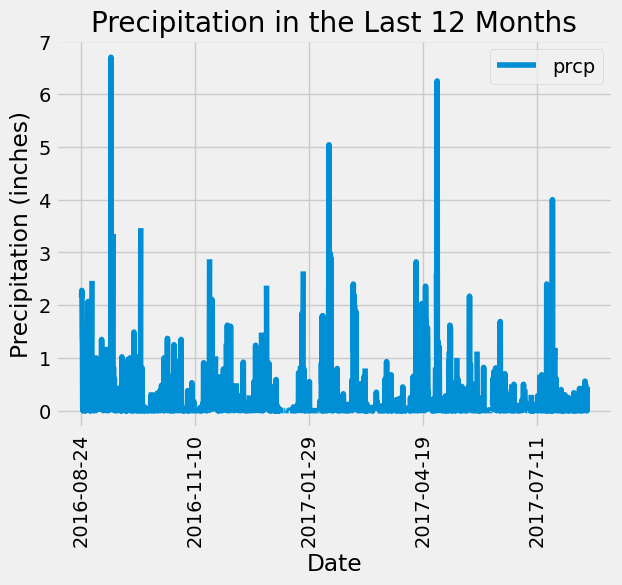

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 

# Step 1: Convert the most recent date to a datetime object
from datetime import datetime

latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date = datetime.strptime(latest_date, '%Y-%m-%d')

# Step 2: Calculate the date 12 months prior to the most recent date
one_year_ago = latest_date.replace(year=latest_date.year - 1)

# Step 3: Query the database to retrieve precipitation data
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Step 4: Load the query results into a pandas dataframe
df = pd.DataFrame(results, columns=['date', 'prcp'])

# Step 5: Set the dataframe index to the date column
df.set_index('date', inplace=True)

# Step 6: Sort the dataframe by date
df.sort_index(inplace=True)

# Step 7: Plot the precipitation data
df.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation in the Last 12 Months')
plt.show()


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(f'Total number of stations: {total_stations}')


Total number of stations: 9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
results = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
# print(results)

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Query to calculate the total number of stations
total_stations = session.query(func.count(Station.station)).scalar()

# Query to find the most active station
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
                      group_by(Measurement.station).\
                      order_by(func.count(Measurement.station).desc()).\
                      first()[0]

print(most_active_station)

# Query to get temperature data for the most active station
temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == most_active_station).all()

# Print the results
if temps[0][0] is not None:
    print(f"Lowest temperature: {temps[0][0]}")
else:
    print("No temperature data available.")
    
if temps[0][1] is not None:
    print(f"Highest temperature: {temps[0][1]}")
else:
    print("No temperature data available.")
    
if temps[0][2] is not None:
    print(f"Average temperature: {round(temps[0][2], 2)}")
else:
    print("No temperature data available.")


USC00519281
Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66


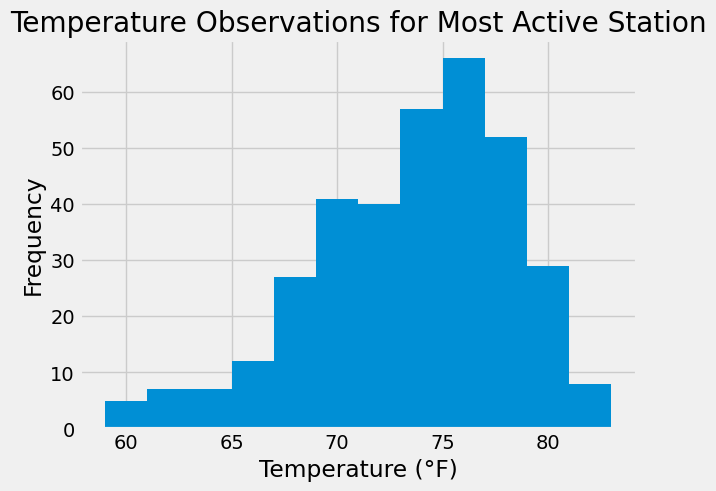

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Query to get the most recent date in the dataset
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

# Calculate the date 1 year ago from the latest date
one_year_ago = dt.datetime.strptime(latest_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Query to get temperature data for the most active station in the last 12 months
temps = session.query(Measurement.tobs).\
        filter(Measurement.station == most_active_station).\
        filter(Measurement.date >= one_year_ago).\
        order_by(Measurement.date).all()

# Create a Pandas DataFrame with the temperature data
temps_df = pd.DataFrame(temps, columns=["Temperature"])

# Plot the results as a histogram with 12 bins
plt.hist(temps_df["Temperature"], bins=12)
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title("Temperature Observations for Most Active Station")
plt.show()

# Close Session

In [18]:
# Close Session
session.close()